# Activity - 1

### Likelihood function is a binomial distribution with N = 100 bernoulli trials. 
### Probability of getting $x$ from a bernoulli distribution is, $P(X=x) = p^x (1-p)^{(1-x)}$ 
### Likelihood, $L(p) = \prod_{n_i=1}^{N} p^{n_i} (1-p)^{(1-n_i)}$ 
### $\log {L(p)} = \sum_{n_i=1}^{N} (n_i \log{p} + (1-n_i) \log{(1-p)})$
### suppose, $k =$ number of heads, $L(k, p) = {N \choose k} p^k(1-p)^{(N-k)}$ 
### $\log{L(k, p)} = \log \left( \frac{N!}{k!(N - k)!} \right) + k\log{p} + (N-k)\log{(1-p)}$ 
### maximization of $L(p)$ in terms of $p$ will give us, 
### $\frac{\partial \log{L(p)}}{\partial p} = \sum_{n_i=1}^{N} (\frac{n_i}{p} - \frac{1-n}{1-p}) = 0$ 
### so, the maximum likelihood estimator of p, $\hat{p} = \frac{\sum_{n_i = 1}^{N} n_i}{N}$

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.special import factorial
from scipy.optimize import fsolve

In [94]:
n, p_true, N = 1, .6, 100 # number of trials, probability of each trial (one binomial trial is N bernoulli trials)
data = np.random.binomial(n, p_true, N) #(N = 100)

In [95]:
print(data)

[1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0
 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0
 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1]


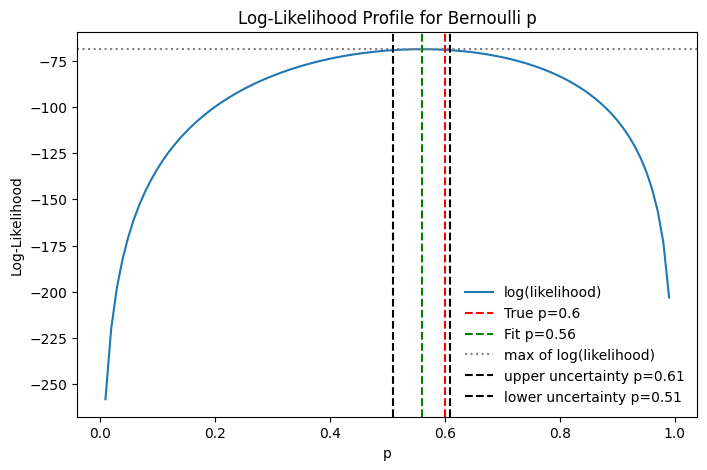

In [111]:
# Step 2: Define the MLE for p and the log-likelihood function
def log_likelihood(p, data):
    if p <= 0 or p >= 1:
        return -np.inf  # Avoid log(0) issues
    k = np.sum(data)
    #n_tails = len(data) - k
    return np.log(factorial(len(data)/(factorial(k)*factorial(len(data) - k)))) + k*np.log(p) + (len(data)-k)*np.log(1-p)

def func(p, p_fit):
    return log_likelihood(p, data) - log_likelihood(p_fit, data) + 1/2
    

def pfit_uncertainty(p1, data):
    lower_guess = p1 - 0.1  # Initial guess slightly lower than p_fit
    upper_guess = p1 + 0.1  # Initial guess slightly higher than p_fit

    # Use fsolve with two different starting points to find both roots
    p_lower = fsolve(lambda p: func(p, p1), lower_guess)[0]
    p_upper = fsolve(lambda p: func(p, p1), upper_guess)[0]

    return p_lower, p_upper



# MLE estimate of p
p_fit = np.mean(data)  # MLE for Bernoulli is just mean of data

# log-likelihood values
p_values = np.linspace(0.01, 0.99, 100)
logL = np.array([log_likelihood(p, data) for p in p_values])

# uncertainty in p_fit
logL_max = log_likelihood(p_fit, data)
uncertainty_threshold = logL_max - 0.5

# Find values where logL crosses threshold
mask = logL >= uncertainty_threshold
p_bounds = p_values[mask][[0, -1]]   
p_error = (p_fit - p_bounds[0], p_bounds[1] - p_fit)   

# upper and lower uncertainties on p
p_lower, p_upper = pfit_uncertainty(p_fit, data) 


plt.figure(figsize=(8, 5))
plt.plot(p_values, logL, label='log(likelihood)')
plt.axvline(p_true, color='r', linestyle='--', label=f'True p={p_true}')
plt.axvline(p_fit, color='g', linestyle='--', label=f'Fit p={p_fit:.2f}')
#plt.scatter([p_true, p_fit], [log_likelihood(p_true, data), logL_max], color=['red', 'green'])
plt.axhline(logL_max, color='gray', linestyle=':', label="max of log(likelihood)")
plt.axvline(p_upper, color='black', linestyle='--', label=f'upper uncertainty p={p_upper:.2f}')
plt.axvline(p_lower, color='black', linestyle='--', label=f'lower uncertainty p={p_lower:.2f}')
plt.xlabel('p')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Profile for Bernoulli p')
plt.legend(frameon=False)
plt.show()

# Activity - 2

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
from scipy import stats

In [2]:
data_df = pd.read_csv('Activity3.csv', header = None)

In [4]:
data_df.head()
print(len(data_df))

59


In [3]:
t, y, yerr = data_df[0], data_df[1], data_df[2]
exp_t = np.exp(t/100)

#### y = $a_1 e^{-a_2 t} + b_1 e^{-b_2 t} + c_1 t$
#### t = log(x)   or,   $x = e^t$, but taken as $x = e^{t/100}$ (to rescale so $e^{800}$ doesn't return inf)
#### y = $a_1 e^{-100 a_2 log(x)} + b_1 e^{-100 b_2 log(x)} + 100 c_1 log(x) + c_2$
#### y = $a_1 x^{-100 a_2} + b_1 x^{-100 b_2} + 100 c_1 log(x) + c_2$

In [4]:
def fit_func(x, a1, a2, b1, b2, c1):
    return a1*(x**-a2) + b1*(x**-b2) + c1*np.log(x)

In [5]:
least_squares = LeastSquares(exp_t, y, yerr, fit_func)
m = Minuit(least_squares, a1=100, a2=0.5, b1=100, b2=1, c1=1)

m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 69.05 (χ²/ndof = 1.3)      │              Nfcn = 449              │
│ EDM = 6.33e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │    128    │    18     │            │            │         │         │       │
│ 1 │ a2   │   0.40    │   0.05    │            │            │         │         │       │
│ 2 │ b1   │    960    │    50     │            │            │         │         │       │
│ 3 │ b2   │   2.85    │   0.21    │            │            │         │         │       │
│ 4 │ c1   │   0.99    │   0.25    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────┐
│    │       a1       a2       b1       b2       c1 │
├────┼──────────────────────────────────────────────┤
│ a1 │      342   0.8961   0.17e3     3.03     3.53 │
│ a2 │   0.8961  0.00257   0.3291   0.0074   0.0111 │
│ b1 │   0.17e3   0.3291 2.46e+03     6.57     0.81 │
│ b2 │     3.03   0.0074     6.57   0.0423     0.03 │
│ c1 │     3.53   0.0111     0.81     0.03   0.0621 │
└────┴──────────────────────────────────────────────┘

<ValueView a1=128.3247844969397 a2=0.40414339069270167 b1=956.1125935378817 b2=2.849740155584235 c1=0.9881884477538007>


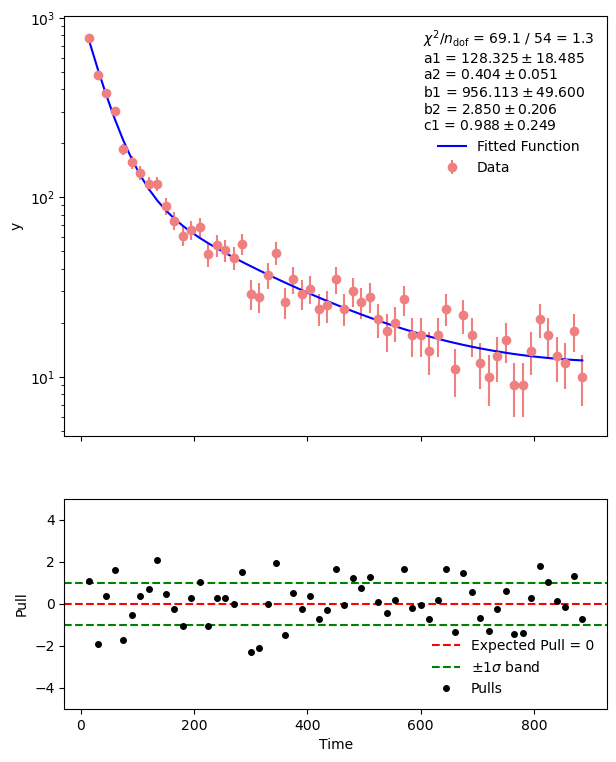

In [8]:
fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=True, sharey=False,
        figsize=(7, 9),
        gridspec_kw={'height_ratios':[2,1]}
        )

axes[0].errorbar(t, y, yerr, color='lightcoral', fmt = 'o', label = 'Data')
axes[0].plot(t, fit_func(exp_t, *m.values), color='blue', label='Fitted Function')
axes[0].set_yscale("log")
axes[0].set_ylabel("y")

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

axes[0].legend(title="\n".join(fit_info), frameon=False)
print(m.values)

pulls = (y - fit_func(exp_t, *m.values)) / yerr
axes[1].errorbar(t, pulls, fmt='o', color='black', markersize=4, label='Pulls')
axes[1].axhline(0, color='red', linestyle='--', label='Expected Pull = 0')
axes[1].axhline(1, color='green', linestyle='--', label='$\pm 1\sigma$ band')
axes[1].axhline(-1, color='green', linestyle='--')
axes[1].set_ylim(-5, 5)
axes[1].set_ylabel('Pull')
axes[1].set_xlabel('Time')
axes[1].legend(frameon = False)
fig.savefig('fitandpull.png')

In [16]:
#P-VALUE

chi2 = m.fval
n_dof = m.ndof
pvalue = 1 - stats.chi2.cdf(chi2, n_dof) #right tail of chi2 distribution
print(pvalue) #0.08 > 0.05, so follows the null hypothesis i.e, model and data have good agreements

0.08149058515121865


# Activity - 3         

In [9]:
import h5py
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [10]:
data_x = {} #create dictionaries
data_y = {}

for N in (10, 100, 1000):
    hf = h5py.File(f'data_N{N}.h5', 'r')
    data_x[N] = hf['x'][()]
    data_y[N] = hf['y'][()]
    
#print(data_x[1000], data_y[1000])

In [11]:
def polynomial_basis(x, *params):
    return sum(coeff * x**i for i, coeff in enumerate(params))

def gaussian_basis(x, *params):
    mu = np.linspace(min(x), max(x), 11)  # 11 centers
    sigma = 0.5  # Standard deviation as scale
    return sum(p*np.exp(-(x - mu_i)**2 / (2 * sigma**2)) for p, mu_i in zip(params, mu))

def sigmoidal_basis(x, *params):
    mu = np.linspace(min(x), max(x), 11)  # 11 centers
    s = np.std(x)  # Scale parameter
    return sum(p / (1 + np.exp(-(x - mu_i) / s)) for p, mu_i in zip(params, mu))

def chi_square(model, popt, x, y, N):
    # Compute residuals (difference between the data and model prediction)
    residuals = (y - model(x, *popt))/0.3  # 0.3 taken since it is noise of our data
    reduced_chi_squared = (np.sum(residuals**2))/(N - len(popt))
    return reduced_chi_squared

### using scipy for fitting here because no y_errors included here and using iminuit would be an overkill

In [12]:
#curve_fit by default uses the least squares optimization
popt_poly, _ = curve_fit(polynomial_basis, data_x[100], data_y[100], p0=np.ones(12))
popt_gauss, _ = curve_fit(gaussian_basis, data_x[100], data_y[100], p0=np.ones(11))
popt_sigm, _ = curve_fit(sigmoidal_basis, data_x[100], data_y[100], p0=np.ones(11))

#calculate reduced chi2
chi2_poly = chi_square(polynomial_basis, popt_poly, data_x[100], data_y[100], 100)
chi2_gauss = chi_square(gaussian_basis, popt_gauss, data_x[100], data_y[100], 100)
chi2_sigm = chi_square(sigmoidal_basis, popt_sigm, data_x[100], data_y[100], 100)

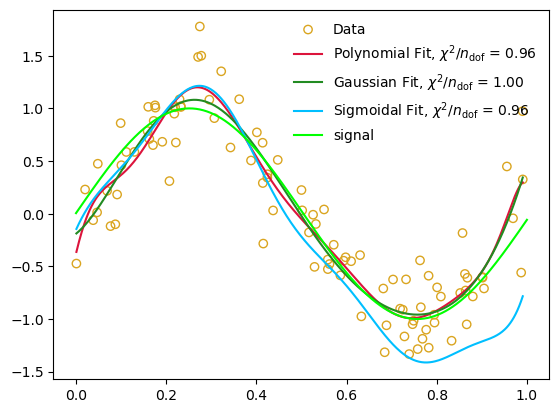

In [16]:
x_continuous = np.linspace(data_x[100].min(), data_x[100].max(), 500)
plt.scatter(data_x[100], data_y[100], facecolors='none', edgecolors='goldenrod', marker='o', label='Data')
plt.plot(x_continuous, polynomial_basis(x_continuous, *popt_poly), c='crimson', label=f'Polynomial Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_poly:0.2f}')
plt.plot(x_continuous, gaussian_basis(x_continuous, *popt_gauss), c='forestgreen', label=f'Gaussian Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_gauss:0.2f}')
plt.plot(x_continuous, sigmoidal_basis(x_continuous, *popt_sigm), c='deepskyblue', label=f'Sigmoidal Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_sigm:0.2f}')
plt.plot(np.linspace(0, 1, 500), np.sin(2*np.pi*x_continuous), c='lime', label='signal')
plt.legend(frameon = False)
plt.savefig('lstsq10')

In [14]:
popt_poly2, _ = curve_fit(polynomial_basis, data_x[1000], data_y[1000], p0=np.ones(12))
popt_gauss2, _ = curve_fit(gaussian_basis, data_x[1000], data_y[1000], p0=np.ones(11))
popt_sigm2, _ = curve_fit(sigmoidal_basis, data_x[1000], data_y[1000], p0=np.ones(11))

#calculate reduced chi2
chi2_poly2 = chi_square(polynomial_basis, popt_poly2, data_x[1000], data_y[1000], 1000)
chi2_gauss2 = chi_square(gaussian_basis, popt_gauss2, data_x[1000], data_y[1000], 1000)
chi2_sigm2 = chi_square(sigmoidal_basis, popt_sigm2, data_x[1000], data_y[1000], 1000)
print(chi2_sigm2)

1.04295336512336


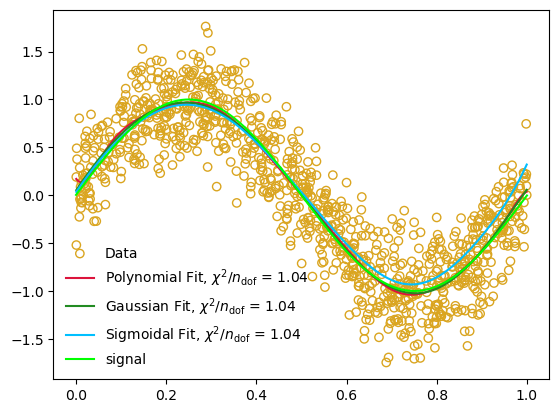

In [17]:
x_continuous = np.linspace(data_x[1000].min(), data_x[1000].max(), 500)
plt.scatter(data_x[1000], data_y[1000], facecolors='none', edgecolors='goldenrod', marker='o', label='Data')
plt.plot(x_continuous, polynomial_basis(x_continuous, *popt_poly2), c='crimson', label=f'Polynomial Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_poly2:0.2f}')
plt.plot(x_continuous, gaussian_basis(x_continuous, *popt_gauss2), c='forestgreen', label=f'Gaussian Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_gauss2:0.2f}')
plt.plot(x_continuous, sigmoidal_basis(x_continuous, *popt_sigm2), c='deepskyblue', label=f'Sigmoidal Fit, $\chi^2$/$n_\mathrm{{dof}}$ = {chi2_sigm2:0.2f}')
plt.plot(np.linspace(0, 1, 500), np.sin(2*np.pi*x_continuous), c='lime', label='signal')
plt.legend(frameon = False)
plt.savefig('lstsq100')

### bayesian linear regression

In [18]:
def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power

def sigmoidal_basis_function(x, mu):
    s = np.std(x)
    return 1 /(1 + np.exp(-(x - mu)/s))


def get_phi(x, bf, bf_args):
    ones = np.ones((x.shape[0], 1))   # Bias term (intercept) should be first column
    basis_functions = [bf(x, bf_arg).reshape(-1, 1) for bf_arg in bf_args]
    return np.hstack((ones, *basis_functions))

In [19]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    #Computes mean and covariance matrix of the posterior distribution
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def posterior_predictive(Phi_test, m_N, S_N, beta):
    #Computes mean and variances of the posterior predictive distribution
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [20]:
alpha = 0.005
beta = 11.1

## Polynomial basis function - 

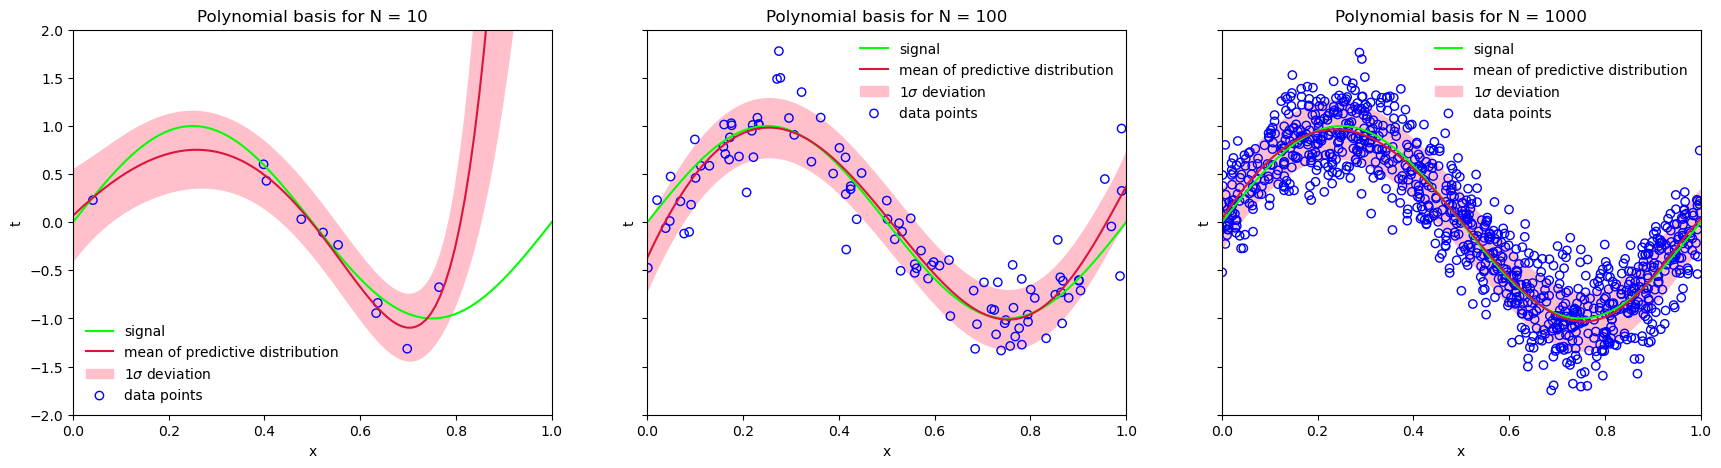

In [22]:
degree = 11
degrees = range(degree + 1)

N = np.array([10, 100, 1000])
fig, axs = plt.subplots(1, 3, figsize=(21, 5), sharex=True, sharey=True)

for i, val in enumerate(N):
    
    x_N, y_N = data_x[val], data_y[val]
    x_test = np.linspace(0, 1, 100)

    Phi_N = get_phi(x_N, bf=polynomial_basis_function, bf_args=degrees[1:])
    Phi_test = get_phi(x_test, bf=polynomial_basis_function, bf_args=degrees[1:])
    
    #mean and covariance matrix of posterior distribution
    m_N, S_N = posterior(Phi_N, y_N, alpha, beta)
    
    #mean and variance of posterior predictive
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    upper = y + np.sqrt(y_var)
    lower = y - np.sqrt(y_var)

    axs[i].plot(x_test, np.sin(2*np.pi*x_test), c = 'lime', label = "signal")
    axs[i].plot(x_test, y, c ='crimson', label = 'mean of predictive distribution')
    axs[i].fill_between(x_test, upper, lower, color ='pink', label = '$1\sigma$ deviation')
    axs[i].scatter(x_N, y_N, facecolors='none', edgecolors='blue', marker = 'o', label = 'data points')
    axs[i].set_xlim(0.0, 1.0)
    axs[i].set_ylim(-2, 2)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("t")
    axs[i].set_title(f"Polynomial basis for N = {val}")
    axs[i].legend(frameon = False)
fig.savefig('bayes10.png')

## Gaussian basis function - 

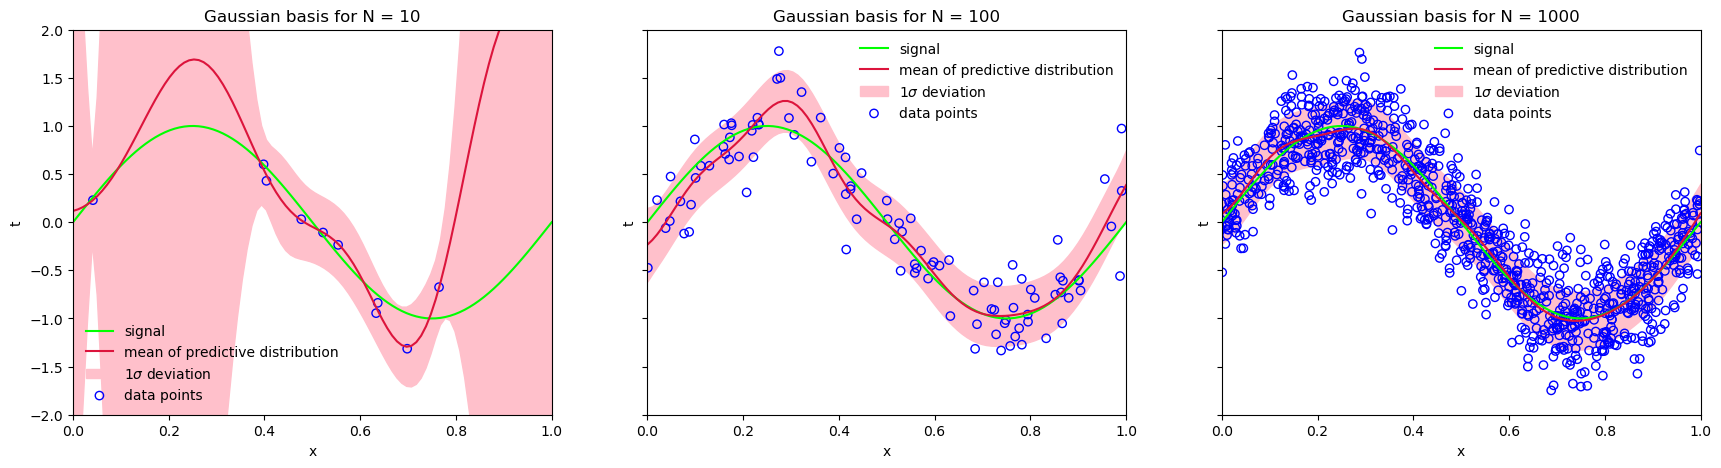

In [23]:
N = np.array([10, 100, 1000])
fig, axs = plt.subplots(1, 3, figsize=(21, 5), sharex=True, sharey=True)

for i, val in enumerate(N):
    
    x_N, y_N = data_x[val], data_y[val]
    x_test = np.linspace(0, 1, 100)

    #11 basis functions but 12 parameters
    Phi_N = get_phi(x_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 11)) #with training set 
    Phi_test = get_phi(x_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 11))
    
    #mean and covariance matrix of posterior distribution
    m_N, S_N = posterior(Phi_N, y_N, alpha, beta)
    
    #mean and variance of posterior predictive
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    upper = y + np.sqrt(y_var)
    lower = y - np.sqrt(y_var)

    axs[i].plot(x_test, np.sin(2*np.pi*x_test), c = 'lime', label = "signal")
    axs[i].plot(x_test, y, c ='crimson', label = 'mean of predictive distribution')
    axs[i].fill_between(x_test, upper, lower, color ='pink', label = '$1\sigma$ deviation')
    axs[i].scatter(x_N, y_N, facecolors='none', edgecolors='blue', marker = 'o', label = 'data points')
    axs[i].set_xlim(0.0, 1.0)
    axs[i].set_ylim(-2, 2)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("t")
    axs[i].set_title(f"Gaussian basis for N = {val}")
    axs[i].legend(frameon = False)

fig.savefig('bayes100.png')

## Sigmoid basis function

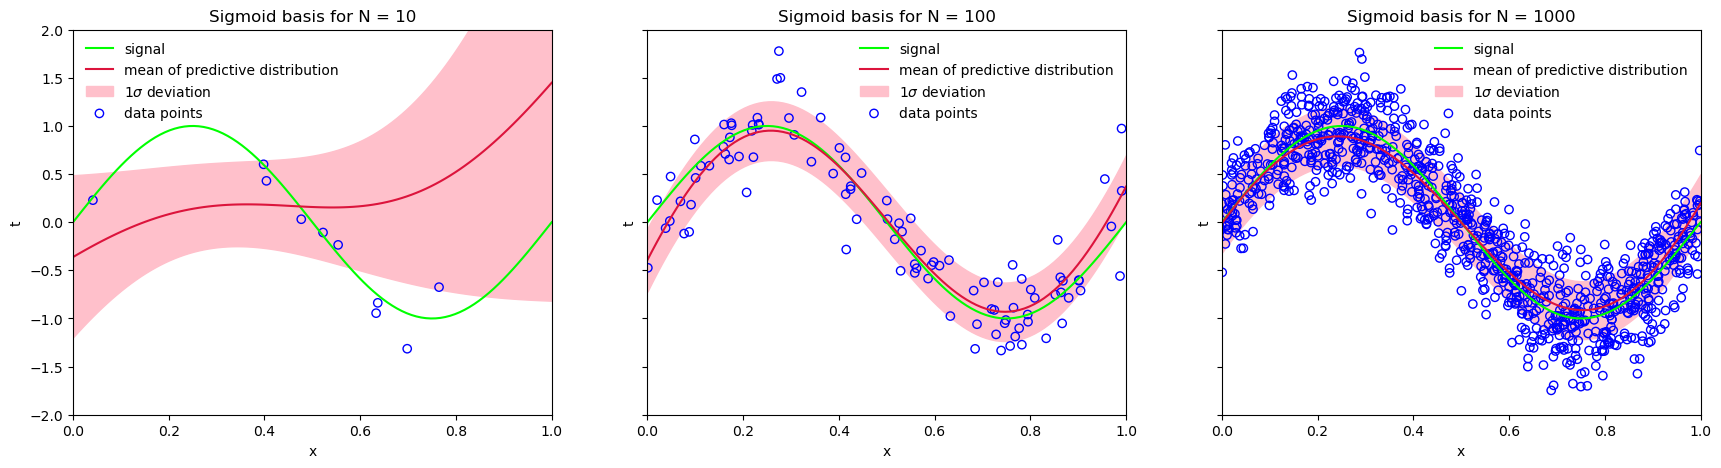

In [24]:
N = np.array([10, 100, 1000])
fig, axs = plt.subplots(1, 3, figsize=(21, 5), sharex=True, sharey=True)



for i, val in enumerate(N):
    
    x_N, y_N = data_x[val], data_y[val]
    x_test = np.linspace(0, 1, 100)

    #11 basis functions but 12 parameters
    Phi_N = get_phi(x_N, bf=sigmoidal_basis_function, bf_args=np.linspace(0, 1, 11)) #with training set 
    Phi_test = get_phi(x_test, bf=sigmoidal_basis_function, bf_args=np.linspace(0, 1, 11))
    
    #mean and covariance matrix of posterior distribution
    m_N, S_N = posterior(Phi_N, y_N, alpha, beta)
    
    #mean and variance of posterior predictive
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    upper = y + np.sqrt(y_var)
    lower = y - np.sqrt(y_var)

    axs[i].plot(x_test, np.sin(2*np.pi*x_test), c = 'lime', label = "signal")
    axs[i].plot(x_test, y, c ='crimson', label = 'mean of predictive distribution')
    axs[i].fill_between(x_test, upper, lower, color ='pink', label = '$1\sigma$ deviation')
    axs[i].scatter(x_N, y_N, facecolors='none', edgecolors='blue', marker = 'o', label = 'data points')
    axs[i].set_xlim(0.0, 1.0)
    axs[i].set_ylim(-2, 2)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("t")
    axs[i].set_title(f"Sigmoid basis for N = {val}")
    axs[i].legend(frameon = False)

fig.savefig('bayes1000.png')